# RandomForest Regressor를 사용한 택시 수요 예측  
   
1. yesterday,today,tomorrow 변수 -> 하나의 변수(ytt)로 통합
2. hour(시간대), ytt(어제,오늘,내일 휴일 여부 ex) 전부 휴일 : 111) 변수 카테고리형 타입 변환
3. target(count) 종속변수 LOG변환 X, LOG변환 O 두가지 경우의 RMSE값 비교 확인
4. 원본 데이터의 2018-10-09 한글날 Update X, Update O 두가지 경우 해당일 예측 비교 확인 
5. GridSearchCV 를 통한 랜덤포레스트의 하이퍼 파라미터 튜닝  
5. K-Fold 교차검증
6. TimeSeriesSplit 시계열 교차검증
7. 최종예측 & 성능평가

## 필요한 모듈 import

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import missingno as msno

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
from matplotlib import rc

# 시각화 그래프 '-' & 한글 깨짐 현상 처리
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

mpl.rcParams['axes.unicode_minus'] = False
font_name = fm.FontProperties(fname='c:\\windows\\fonts\\malgun.ttf').get_name()
rc('font', family=font_name)

# 경고메시지 숨김
import warnings
warnings.filterwarnings(action='ignore')
# 경고메시지 다시 보이게
#warnings.filterwarnings(action='default')

## 데이터 준비

### 데이터로드

In [12]:
# 유동인구 없는 데이터
taxi = pd.read_csv("data/T-Money/seolleung_dataset.csv", parse_dates=["o_time"])
taxi['hour'] = taxi['o_time'].dt.hour
taxi['ytt'] = taxi[['yesterday', 'today', 'tomorrow']].apply(lambda x: ''.join(x.astype(str)), axis=1)
taxi = taxi[['o_time', 'hour', 'ytt', 'temp', 'windspeed', 'humidity', 'cloud', 'precipitation', 
             'snowcover', 'visibility', 'user', 'count']]
taxi.head()

,o_time,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count
0,2018-10-01 00:00:00,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,52
1,2018-10-01 01:00:00,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,17
2,2018-10-01 02:00:00,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,10
3,2018-10-01 03:00:00,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,13
4,2018-10-01 04:00:00,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,12


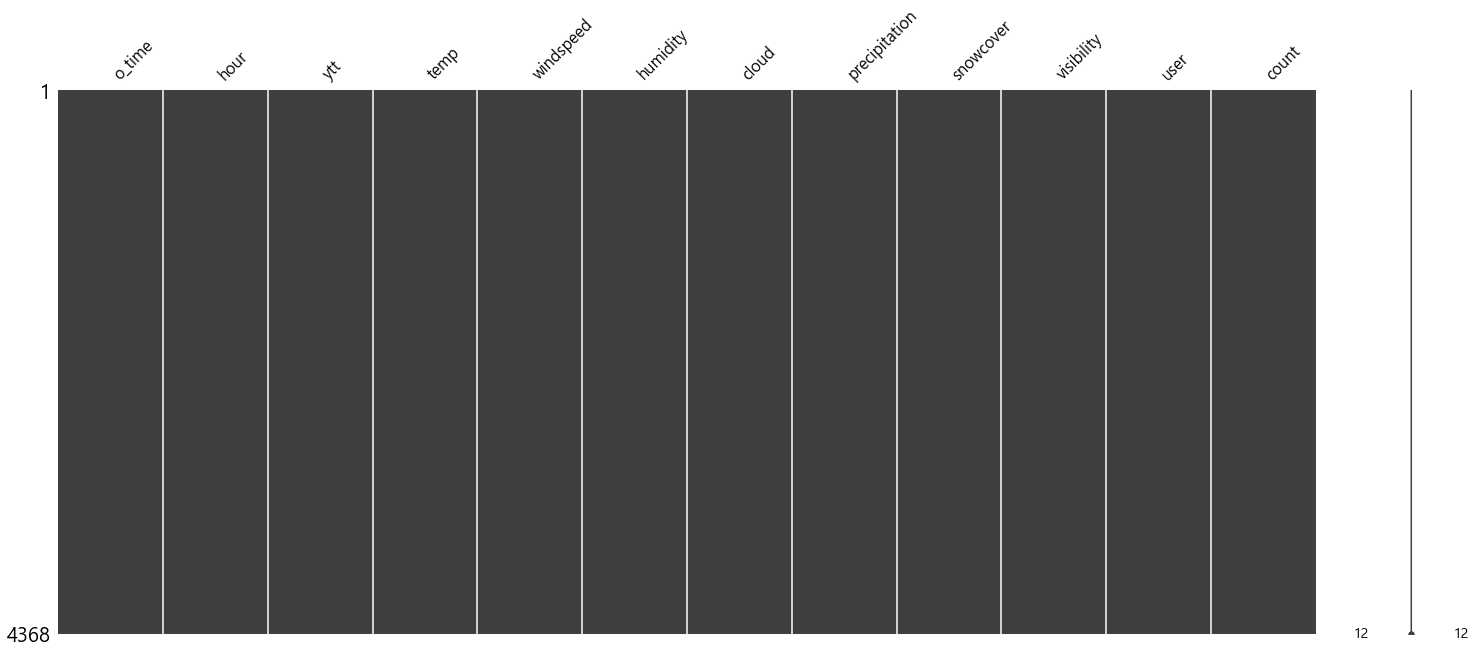

In [289]:
msno.matrix(taxi)

__한글날 ytt 업데이트__

In [13]:
taxi.set_index('o_time', inplace=True)
taxi['2018-10-08'].ytt = '101'
taxi['2018-10-09'].ytt = '010'
taxi['2018-10-10'].ytt = '100'
taxi['2018-10-08':'2018-10-10']
taxi.reset_index(inplace=True)

In [14]:
taxi = taxi.drop(['visibility','cloud','windspeed'],axis=1)
taxi['day_of_week'] = taxi['o_time'].dt.weekday
taxi

,o_time,hour,ytt,temp,humidity,precipitation,snowcover,user,count,day_of_week
0,2018-10-01 00:00:00,0,100,14.1,55,0.0,0.0,1.0,52,0
1,2018-10-01 01:00:00,1,100,13.9,57,0.0,0.0,1.0,17,0
2,2018-10-01 02:00:00,2,100,13.9,56,0.0,0.0,1.0,10,0
3,2018-10-01 03:00:00,3,100,13.6,56,0.0,0.0,1.0,13,0
4,2018-10-01 04:00:00,4,100,13.7,56,0.0,0.0,1.0,12,0
5,2018-10-01 05:00:00,5,100,13.7,57,0.0,0.0,1.0,8,0
6,2018-10-01 06:00:00,6,100,13.3,56,0.0,0.0,1.0,14,0
7,2018-10-01 07:00:00,7,100,13.1,58,0.0,0.0,1.0,31,0
8,2018-10-01 08:00:00,8,100,13.7,54,0.0,0.0,1.0,148,0
9,2018-10-01 09:00:00,9,100,14.9,50,0.0,0.0,1.0,130,0


In [15]:
def prec_transform(x):
    if x < 0.1: 
        return 0
    
    elif 0.1 <= x < 1.0: 
        return 1
    
    elif 1.0 <= x < 5.0: 
        return 5
    
    elif 5.0 <= x < 10.0:
        return 10
    
    elif 10.0 <= x < 20.0:
        return 20
    
    elif 20.0 <= x < 40.0:
        return 40
    
    elif 40.0 <= x < 70.0:
        return 70
    
    elif x >= 70.0:
        return 100
        
taxi['precipitation'] = taxi['precipitation'].apply(prec_transform)

In [16]:
def snow_transform(x):
    if x < 0.1: 
        return 0
    
    elif 0.1 <= x < 1.0: 
        return 1
    
    elif 1.0 <= x < 5.0: 
        return 5
    
    elif 5.0 <= x < 10.0:
        return 10
    
    elif 10.0 <= x < 20.0:
        return 20
    
    elif x >= 20 :
        return 100
        
taxi['snowcover'] = taxi['snowcover'].apply(snow_transform)

In [17]:
taxi.describe()

,hour,temp,humidity,precipitation,snowcover,user,count,day_of_week
count,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000
mean,11.500000,4.624428,51.187271,0.114240,0.081273,0.996694,75.315705,3.000000
std,6.922979,7.028631,20.090093,0.923201,0.625053,0.036326,44.290575,2.000229
min,0.000000,-14.200000,10.000000,0.000000,0.000000,0.490000,5.000000,0.000000
25%,5.750000,-0.300000,35.000000,0.000000,0.000000,1.000000,38.000000,1.000000
50%,11.500000,4.300000,49.000000,0.000000,0.000000,1.000000,70.000000,3.000000
75%,17.250000,9.700000,66.000000,0.000000,0.000000,1.000000,100.000000,5.000000
max,23.000000,25.300000,98.000000,20.000000,10.000000,1.000000,231.000000,6.000000


In [4]:
# 유동인구 컬럼 추가한 데이터
taxi_add_pop = pd.read_csv("data/T-Money/seolleung_dataset_add_pop.csv", parse_dates=["o_time"])
taxi_add_pop['hour'] = taxi_add_pop['o_time'].dt.hour
taxi_add_pop['ytt'] = taxi_add_pop[['yesterday', 'today', 'tomorrow']].apply(lambda x: ''.join(x.astype(str)), axis=1)
taxi_add_pop = taxi_add_pop[['o_time', 'hour', 'ytt', 'temp', 'windspeed', 'humidity', 'cloud', 'precipitation', 
                             'snowcover', 'visibility', 'user', 'pop', 'count']]
taxi_add_pop.head()

,o_time,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,pop,count
0,2018-10-01 00:00:00,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,299.31,52
1,2018-10-01 01:00:00,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,196.59,17
2,2018-10-01 02:00:00,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,173.37,10
3,2018-10-01 03:00:00,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,131.52,13
4,2018-10-01 04:00:00,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,254.17,12


__한글날 ytt 업데이트__

In [26]:
taxi_add_pop.set_index('o_time', inplace=True)
taxi_add_pop['2018-10-08'].ytt = '101'
taxi_add_pop['2018-10-09'].ytt = '010'
taxi_add_pop['2018-10-10'].ytt = '100'
taxi_add_pop['2018-10-08':'2018-10-10']
taxi_add_pop.reset_index(inplace=True)

### 명목형 변수(hour,ytt) type category로 변경

In [18]:
# 범주형 feature의 type을 category로 변경 해 준다.
taxi['hour'] = taxi['hour'].astype('category')
taxi['ytt'] = taxi['ytt'].astype('category')
taxi['day_of_week'] = taxi['day_of_week'].astype('category')
#taxi['precipitation'] = taxi['precipitation'].astype('int64')#.astype('category')
#taxi['snowcover'] = taxi['snowcover'].astype('int64').astype('category')
#taxi['cloud'] = taxi['cloud'].astype('category')

#taxi_add_pop['hour'] = taxi_add_pop['hour'].astype('category')
#taxi_add_pop['ytt'] = taxi_add_pop['ytt'].astype('category')

print(taxi.info())
#print(taxi_add_pop.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
o_time           4368 non-null datetime64[ns]
hour             4368 non-null category
ytt              4368 non-null category
temp             4368 non-null float64
humidity         4368 non-null int64
precipitation    4368 non-null int64
snowcover        4368 non-null int64
user             4368 non-null float64
count            4368 non-null int64
day_of_week      4368 non-null category
dtypes: category(3), datetime64[ns](1), float64(2), int64(4)
memory usage: 253.3 KB
None


In [9]:
taxi.describe()

,temp,humidity,precipitation,snowcover,user,count
count,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000
mean,4.624428,51.187271,0.114240,0.081273,0.996694,75.315705
std,7.028631,20.090093,0.923201,0.625053,0.036326,44.290575
min,-14.200000,10.000000,0.000000,0.000000,0.490000,5.000000
25%,-0.300000,35.000000,0.000000,0.000000,1.000000,38.000000
50%,4.300000,49.000000,0.000000,0.000000,1.000000,70.000000
75%,9.700000,66.000000,0.000000,0.000000,1.000000,100.000000
max,25.300000,98.000000,20.000000,10.000000,1.000000,231.000000


In [10]:
taxi.drop(['count'],axis=1)[['o_time','temp', 'humidity','precipitation','snowcover','hour','day_of_week','ytt','user']]\
            .to_csv('SEOUL_weather_and_feature_1810-1903.csv', index=False)

### 요일컬럼 추가 데이터셋 생성

In [402]:
# 유동인구 없는 데이터
taxi_add_weekday = taxi.set_index('o_time',inplace=False).reset_index()
taxi_add_weekday['day'] = taxi_add_weekday['o_time'].dt.weekday
taxi_add_weekday.head()

,o_time,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count,day
0,2018-10-01 00:00:00,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,52,0
1,2018-10-01 01:00:00,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,17,0
2,2018-10-01 02:00:00,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,10,0
3,2018-10-01 03:00:00,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,13,0
4,2018-10-01 04:00:00,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,12,0


__요일 컬럼 카테고리형 변환__

In [403]:
taxi_add_weekday['day'] = taxi_add_weekday['day'].astype('category')
taxi_add_weekday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 13 columns):
o_time           4368 non-null datetime64[ns]
hour             4368 non-null category
ytt              4368 non-null category
temp             4368 non-null float64
windspeed        4368 non-null float64
humidity         4368 non-null int64
cloud            4368 non-null float64
precipitation    4368 non-null float64
snowcover        4368 non-null float64
visibility       4368 non-null int64
user             4368 non-null float64
count            4368 non-null int64
day              4368 non-null category
dtypes: category(3), datetime64[ns](1), float64(6), int64(3)
memory usage: 355.7 KB


In [404]:
# 유동인구 추가한 데이터
taxipop_add_weekday = taxi_add_pop.set_index('o_time',inplace=False).reset_index()
taxipop_add_weekday['day'] = taxipop_add_weekday['o_time'].dt.weekday_name
taxipop_add_weekday.head()

,o_time,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,pop,count,day
0,2018-10-01 00:00:00,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,299.31,52,Monday
1,2018-10-01 01:00:00,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,196.59,17,Monday
2,2018-10-01 02:00:00,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,173.37,10,Monday
3,2018-10-01 03:00:00,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,131.52,13,Monday
4,2018-10-01 04:00:00,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,254.17,12,Monday


__요일 컬럼 카테고리형 변환__

In [405]:
taxipop_add_weekday['day'] = taxi_add_weekday['day'].astype('category')
taxipop_add_weekday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 14 columns):
o_time           4368 non-null datetime64[ns]
hour             4368 non-null category
ytt              4368 non-null category
temp             4368 non-null float64
windspeed        4368 non-null float64
humidity         4368 non-null int64
cloud            4368 non-null float64
precipitation    4368 non-null float64
snowcover        4368 non-null float64
visibility       4368 non-null int64
user             4368 non-null float64
pop              4368 non-null float64
count            4368 non-null int64
day              4368 non-null category
dtypes: category(3), datetime64[ns](1), float64(7), int64(3)
memory usage: 389.8 KB


### o_time 컬럼 제거

In [19]:
data1 = taxi.drop(['o_time'],axis=1, inplace=False)

#data2 = taxi_add_pop.drop(['o_time'],axis=1, inplace=False)

#data3 = taxi_add_weekday.drop(['o_time'],axis=1, inplace=False)

#data4 = taxipop_add_weekday.drop(['o_time'],axis=1, inplace=False)

## 훈련, 검증 데이터셋 분리

### feature, target 분리

In [22]:
y_target1 = data1['count']
X_data1 = data1.drop(['count'], axis=1, inplace=False)

#y_target2 = data2['count']
#X_data2 = data2.drop(['count'], axis=1, inplace=False)

#y_target3 = data3['count']
#X_data3 = data3.drop(['count'], axis=1, inplace=False)

#y_target4 = data4['count']
#X_data4 = data4.drop(['count'], axis=1, inplace=False)

### 훈련, 검증 데이터셋 분리

-- 2019-02-05 설 마지막날의 row 확인

In [64]:
taxi[taxi['o_time']=='2019-02-05 23:00:00']

,o_time,yesterday,today,tomorrow,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count,hour
3071,2019-02-05 23:00:00,1,1,1,2.7,1.4,41,6.0,0.0,0.0,939,1.0,26,23


-- 순서대로 훈련 : 7 , 테스트 : 3 split

In [178]:
# 유동인구 x 요일 x
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_data1, y_target1, test_size=0.3, shuffle=False)

# 유동인구 o 요일 x
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_data2, y_target2, test_size=0.3, shuffle=False)

# 유동인구 o 요일 x
#X_train3, X_test3, y_train3, y_test3 = train_test_split(X_data3, y_target3, test_size=0.3, shuffle=False)

# 유동인구 o 요일 o
#X_train4, X_test4, y_train4, y_test4 = train_test_split(X_data4, y_target4, test_size=0.3, shuffle=False)

-- raondom하게 훈련 : 7 , 테스트 : 3 split

In [23]:
# 유동인구 x 요일 x
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_data1, y_target1, test_size=0.2, random_state=3)

# 유동인구 o 요일 x
#X_train2, X_test2, y_train2, y_test2 = train_test_split(X_data2, y_target2, test_size=0.3, random_state=152)

# 유동인구 o 요일 x
#X_train3, X_test3, y_train3, y_test3 = train_test_split(X_data3, y_target3, test_size=0.3, shuffle=False)

# 유동인구 o 요일 o
#X_train4, X_test4, y_train4, y_test4 = train_test_split(X_data4, y_target4, test_size=0.3, shuffle=False)

-- 7:3 비율로 나뉜 훈련,검증 데이터셋 shuffle (일반 교차검증 시 사용)

In [492]:
# 유동인구 x 요일 x
X_train1, y_train1 = shuffle(X_train1, y_train1)
X_test1, y_test1 = shuffle(X_test1, y_test1)

# 유동인구 o 요일 x
X_train2, y_train2 = shuffle(X_train2, y_train2)
X_test2, y_test2 = shuffle(X_test2, y_test2)

# 유동인구 o 요일 x
X_train3, y_train3 = shuffle(X_train3, y_train3)
X_test3, y_test3 = shuffle(X_test3, y_test3)

# 유동인구 o 요일 o
X_train4, y_train4 = shuffle(X_train4, y_train4)
X_test4, y_test4 = shuffle(X_test4, y_test4)

## 성능평가 함수 생성

In [25]:
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    mae_val = mean_absolute_error(y,pred)
    mse_val = mean_squared_error(y,pred)
    rmse_val = rmse(y,pred)
    rmsle_val = rmsle(y,pred)
    print('MAE : {0:.3f}, MSE : {1:.3F}, RMSE : {2:.3F}, RMSLE : {3:.3F}'.format(mae_val,mse_val,rmse_val,rmsle_val))

## RandomForest 기본모델 생성 및 성능평가 (유동인구 컬럼 X 데이터)

### 모델생성 및 평가

__target log변환 x__

In [56]:
rf_model = RandomForestRegressor(max_depth=15, n_estimators=800)

rf_model.fit(X_train1, y_train1)
pred = rf_model.predict(X_test1)

evaluate_regr(y_test1,pred)

MAE : 9.946, MSE : 193.962, RMSE : 13.927, RMSLE : 0.203


In [38]:
rf_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [57]:
pred = rf_model.predict(total_data1)

evaluate_regr(y_target1,pred)

MAE : 6.167, MSE : 81.994, RMSE : 9.055, RMSLE : 0.135


In [206]:
rf_model.fit(X_train1, y_train1)
pred = rf_model.predict(total_data1)
evaluate_regr(eva['count'],pred)

MAE : 6.249, MSE : 104.634, RMSE : 10.229, RMSLE : 0.156


__target log변환 o__

In [189]:
rf_model = RandomForestRegressor(max_depth=12, n_estimators=200)

y_train1_log = np.log1p(y_train1)
rf_model.fit(X_train1, y_train1_log)

pred = rf_model.predict(X_test1)
pred_log = np.exp(pred)

evaluate_regr(y_test1,pred_log)

MAE : 9.717, MSE : 182.819, RMSE : 13.521, RMSLE : 0.202


__model 상세__

In [439]:
rf_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### feature 중요도 시각화

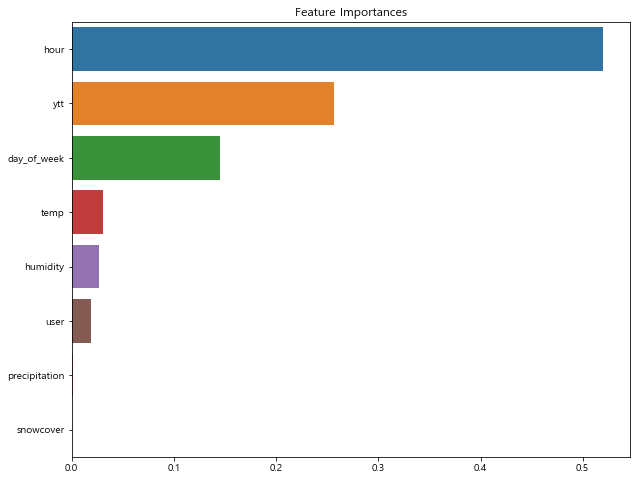

In [317]:
ftr_importances_values = rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train1.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

## GridSearchCV 를 이용한 파라미터 튜닝 (유동인구 컬럼 X 데이터)

### 파라미터 리스트 작성 및 GridSearchCV 사용 튜닝

In [361]:
"""params = [{'bootstrap':[True,False],
           'n_estimators' : [10, 20, 50, 100],
           'max_depth' : [6, 8, 10, 12],
           'max_features': [2,4,6,8,10],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]},
         {'bootstrap':[True,False],
          'n_estimators' : [3,5,7,9,10,50],
          'max_features': [2,4,6,8,10],
          'max_depth' : [6,8,10]}
         ]"""

params = {"n_estimators": [10,50,100,200,500],
          "max_features": ["auto", "log2", "sqrt"],
          "bootstrap": [True, False],
          "max_depth":[6,8,10,12]}

rf_rg = RandomForestRegressor()
cv = KFold(n_splits=5, random_state=1)

gscv = GridSearchCV(rf_rg, params, cv=cv, scoring='neg_mean_squared_error')
gscv.fit(X_train1,y_train1)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 50, 100, 200, 500], 'max_features': ['auto', 'log2', 'sqrt'], 'bootstrap': [True, False], 'max_depth': [6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

### 최적의 파라미터, 해당 파라미터 모델의 MSE

In [362]:
print('final params : ', gscv.best_params_)
print('best RMSE : ', np.sqrt(np.abs(gscv.best_score_)))

final params :  {'bootstrap': True, 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 200}
best RMSE :  15.21362152039235


### 최적의 파라미터로 모델 생성

In [363]:
final_rf_model = gscv.best_estimator_

### 성능 평가

__target log변환 x__

In [90]:
rf_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [214]:
final_rf_model = RandomForestRegressor(max_depth = 12, n_estimators=800, max_leaf_nodes=1000,random_state=2)

final_rf_model.fit(X_train1,y_train1)
pred = final_rf_model.predict(X_test1)

evaluate_regr(y_test1,pred)

MAE : 10.114, MSE : 219.061, RMSE : 14.801, RMSLE : 0.222


In [215]:
final_rf_model.fit(X_train1, y_train1)
pred = final_rf_model.predict(total_data1)
evaluate_regr(eva['count'],pred)

MAE : 7.051, MSE : 109.139, RMSE : 10.447, RMSLE : 0.160


In [ ]:
final_rf_model = gscv.best_estimator_

final_rf_model.fit(X_train1,y_train1)
pred = final_rf_model.predict(X_test1)

evaluate_regr(y_test1,pred)

__target log변환__

In [461]:
final_rf_model = RandomForestRegressor(max_dapth = 12, n_estimators=500)

y_train1_log = np.log1p(y_train1)
rf_model.fit(X_train1, y_train1_log)

pred = rf_model.predict(X_test1)
pred_log = np.exp(pred)

evaluate_regr(y_test1,pred_log)

MAE : 11.656, MSE : 267.054, RMSE : 16.342, RMSLE : 0.271


### feature 중요도 시각화

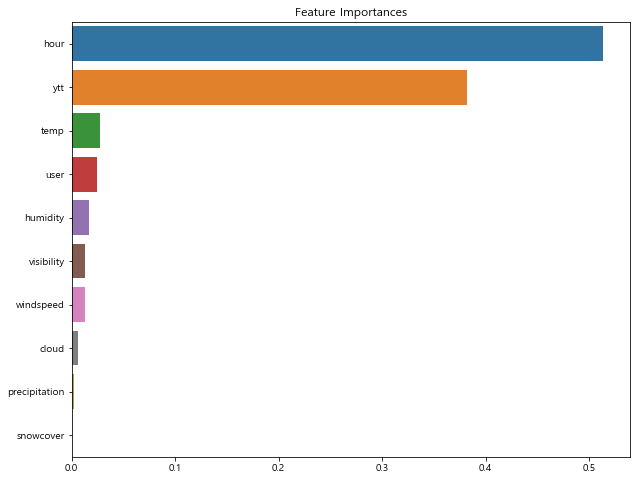

In [462]:
ftr_importances_values = final_rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train1.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

### 튜닝한 파라미터 모델로 전체데이터 예측

In [28]:
total_data1 = data1.drop('count',axis=1,inplace=False)
total_data1

,hour,ytt,temp,humidity,precipitation,snowcover,user,day_of_week
0,0,100,14.1,55,0,0,1.0,0
1,1,100,13.9,57,0,0,1.0,0
2,2,100,13.9,56,0,0,1.0,0
3,3,100,13.6,56,0,0,1.0,0
4,4,100,13.7,56,0,0,1.0,0
5,5,100,13.7,57,0,0,1.0,0
6,6,100,13.3,56,0,0,1.0,0
7,7,100,13.1,58,0,0,1.0,0
8,8,100,13.7,54,0,0,1.0,0
9,9,100,14.9,50,0,0,1.0,0


In [681]:
a = final_rf_model.predict(total_data1)
taxi['pred1'] = a

#taxi.set_index('o_time',inplace=True)

In [686]:
final_rf_model.fit(X_train1,y_train1)
a = final_rf_model.predict(total_data1)
evaluate_regr(taxi['count'],a)

MAE : 6.053, MSE : 96.689, RMSE : 9.833, RMSLE : 0.160


#### 전체기간

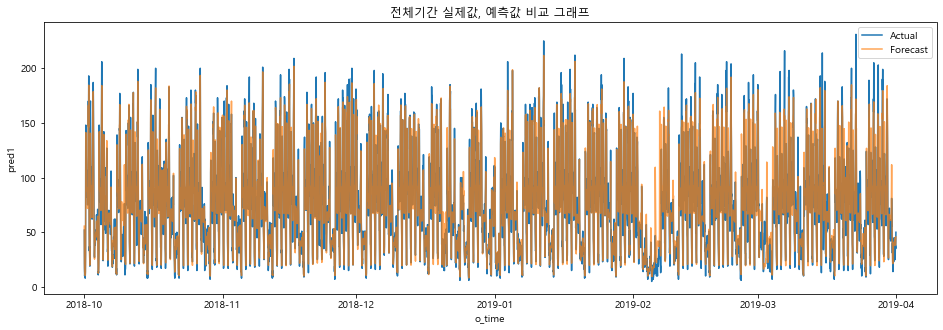

In [466]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi.index,y='count',data=taxi)
sns.lineplot(x=taxi.index,y='pred1',data=taxi,alpha=0.7)
plt.legend(['Actual','Forecast'])
plt.show()

#### 한달

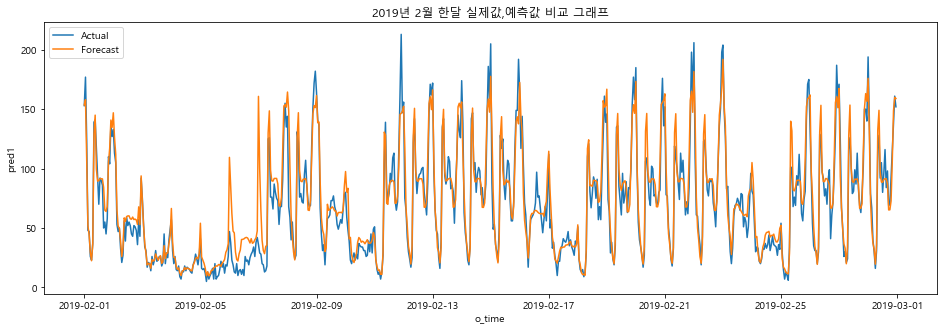

In [467]:
plt.figure(figsize=(16,5))
plt.title('2019년 2월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=taxi['2019-02'].index,y='count',data=taxi['2019-02'])
sns.lineplot(x=taxi['2019-02'].index,y='pred1',data=taxi['2019-02'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 일주일

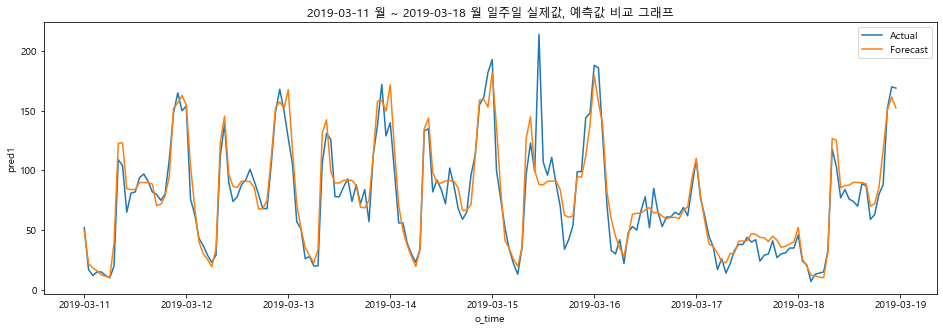

In [468]:
plt.figure(figsize=(16,5))
plt.title('2019-03-11 월 ~ 2019-03-18 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2019-03-11':'2019-03-18'].index,y='count',data=taxi['2019-03-11':'2019-03-18'])
sns.lineplot(x=taxi['2019-03-11':'2019-03-18'].index,y='pred1',data=taxi['2019-03-11':'2019-03-18'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 한글날 ytt 업데이트 x

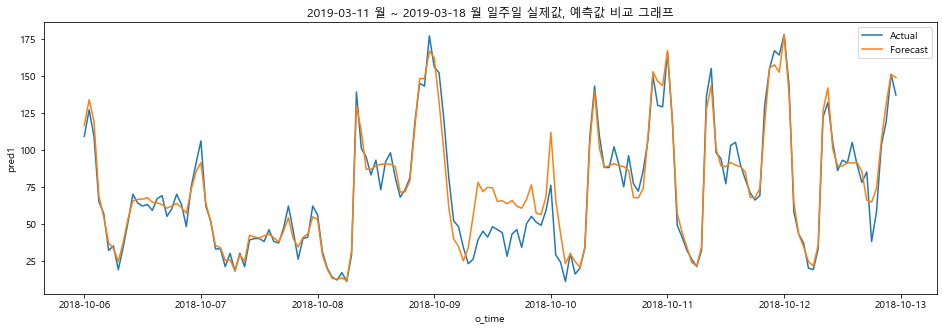

In [469]:
plt.figure(figsize=(16,5))
plt.title('2019-03-11 월 ~ 2019-03-18 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='count',data=taxi['2018-10-06':'2018-10-12'])
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='pred1',data=taxi['2018-10-06':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

### 한글날 ytt 업데이트

2018-10-09 화 한글날

In [218]:
taxi.set_index('o_time',inplace=True)
taxi['ytt'] = taxi['ytt'].astype('str')
taxi['2018-10-08'].ytt = '101'
taxi['2018-10-09'].ytt = '010'
taxi['2018-10-10'].ytt = '100'
taxi['ytt'] = taxi['ytt'].astype('category')
taxi['2018-10-08':'2018-10-10']

,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count
o_time,,,,,,,,,,,
2018-10-08 00:00:00,0,101,12.3,0.8,44,0.0,0.0,0.0,2000,1.0,56
2018-10-08 01:00:00,1,101,11.7,1.1,52,1.0,0.0,0.0,2000,1.0,31
2018-10-08 02:00:00,2,101,11.1,1.4,56,3.0,0.0,0.0,2000,1.0,20
2018-10-08 03:00:00,3,101,10.8,0.5,59,1.0,0.0,0.0,2000,1.0,14
2018-10-08 04:00:00,4,101,10.4,0.6,61,1.0,0.0,0.0,2000,1.0,12
2018-10-08 05:00:00,5,101,9.8,0.5,63,1.0,0.0,0.0,2000,1.0,17
2018-10-08 06:00:00,6,101,9.5,0.9,68,1.0,0.0,0.0,2000,1.0,11
2018-10-08 07:00:00,7,101,9.2,1.0,72,3.0,0.0,0.0,2000,1.0,29
2018-10-08 08:00:00,8,101,9.9,1.2,66,7.0,0.0,0.0,2000,1.0,139


In [223]:
ytt_update = taxi.reset_index(inplace=False)
ytt_update = ytt_update.drop(['o_time','count'],axis=1)
ytt_update.head()

,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user
0,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0
1,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0
2,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0
3,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0
4,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0


In [230]:
b = final_rf_model.predict(ytt_update)
taxi['pred2'] = b

In [231]:
evaluate_regr(taxi['count'],b)

MAE : 6.986, MSE : 107.026, RMSE : 10.345, RMSLE : 0.156


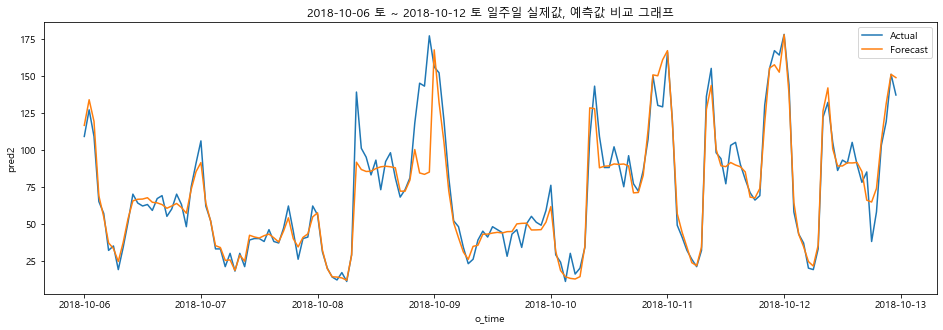

In [474]:
plt.figure(figsize=(16,5))
plt.title('2018-10-06 토 ~ 2018-10-12 토 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='count',data=taxi['2018-10-06':'2018-10-12'])
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='pred2',data=taxi['2018-10-06':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

## RandomForest 기본모델 생성 및 성능평가 (유동인구 컬럼 O 데이터)

### 모델 생성 및 평가

__target log변환 x__

In [698]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train2, y_train2)
pred = rf_model.predict(X_test2)

evaluate_regr(y_test2,pred)

MAE : 11.436, MSE : 245.130, RMSE : 15.657, RMSLE : 0.251


In [702]:
rf_model.fit(X_train2,y_train2)
pred = rf_model.predict(total_data2)
evaluate_regr(eva['count'],pred)

MAE : 6.485, MSE : 108.013, RMSE : 10.393, RMSLE : 0.160


__target log변환__

In [301]:
rf_model = RandomForestRegressor()

y_train2_log = np.log1p(y_train2)
rf_model.fit(X_train2, y_train2_log)

pred = rf_model.predict(X_test2)
pred_log = np.exp(pred)

evaluate_regr(y_test2,pred_log)

MAE : 11.639, MSE : 257.126, RMSE : 16.035, RMSLE : 0.259


__모델 상세__

In [280]:
rf_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### feature 중요도 시각화

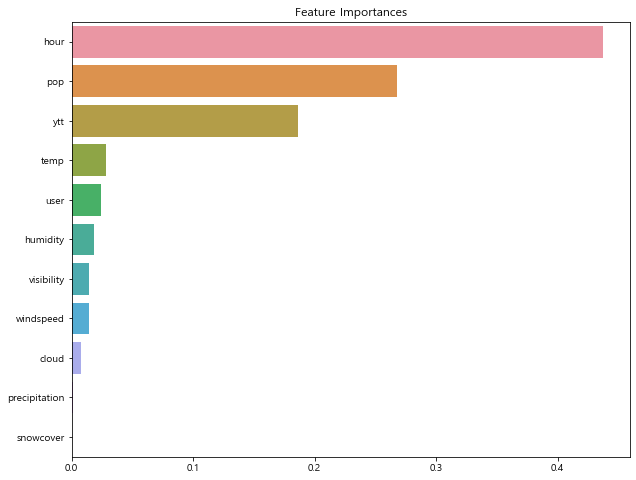

In [281]:
ftr_importances_values = rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train2.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

## GridSearchCV 를 이용한 파라미터 튜닝 (유동인구 컬럼 O 데이터)

### 파라미터 리스트 작성 및 GridSearchCV 사용 튜닝

In [494]:
params = {"n_estimators": [10,50,100,200,500],
          "max_features": ["auto", "log2", "sqrt"]}
""",
          "bootstrap": [True, False],
          "max_depth":[6,8,10,12]}"""

rf_rg = RandomForestRegressor()
#cv = KFold(n_splits=5, random_state=1)
gscv = GridSearchCV(rf_rg, params, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X_train2,y_train2)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 50, 100, 200, 500], 'max_features': ['auto', 'log2', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

### 최적의 파라미터, 해당 파라미터 모델의 MSE

In [495]:
print('final params', gscv.best_params_)
print('best RMSE : ', np.sqrt(np.abs(gscv.best_score_)))

final params {'max_features': 'auto', 'n_estimators': 100}
best RMSE :  15.234810905622103


### 최적의 파라미터로 모델 생성

In [496]:
final_rf_model2 = gscv.best_estimator_

### 성능평가

In [497]:
final_rf_model2 = gscv.best_estimator_

final_rf_model2.fit(X_train2,y_train2)
pred = final_rf_model2.predict(X_test2)

evaluate_regr(y_test2,pred)

MAE : 11.223, MSE : 235.662, RMSE : 15.351, RMSLE : 0.242


### feature 중요도 시각화

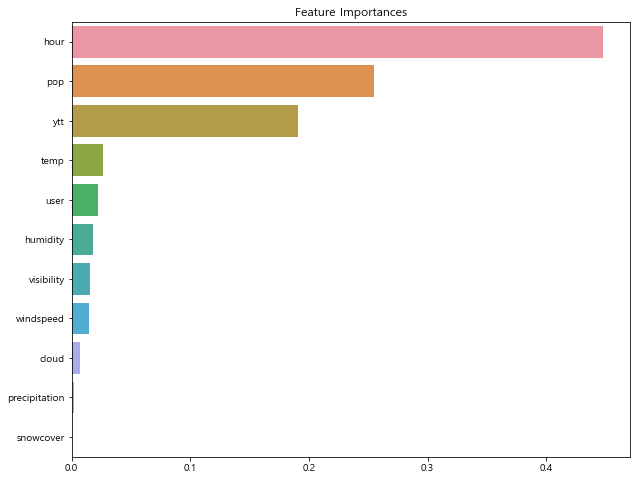

In [498]:
ftr_importances_values = final_rf_model2.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train2.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

### 튜닝한 파라미터 모델로 전체데이터 예측

In [499]:
total_data2 = data2.drop('count',axis=1,inplace=False)
total_data2

,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,pop
0,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,299.31
1,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,196.59
2,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,173.37
3,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,131.52
4,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,254.17
5,5,100,13.7,1.8,57,8.0,0.0,0.0,1999,1.0,1430.63
6,6,100,13.3,2.3,56,7.0,0.0,0.0,2000,1.0,4227.82
7,7,100,13.1,2.1,58,3.0,0.0,0.0,1997,1.0,12881.29
8,8,100,13.7,2.4,54,7.0,0.0,0.0,1960,1.0,15716.97
9,9,100,14.9,3.4,50,1.0,0.0,0.0,1989,1.0,8038.56


In [504]:
b = final_rf_model2.predict(total_data2)
taxi_add_pop['pred1'] = b

taxi_add_pop.set_index('o_time',inplace=True)

In [505]:
evaluate_regr(taxi['count'],b)

MAE : 6.080, MSE : 92.514, RMSE : 9.618, RMSLE : 0.151


#### 전체기간

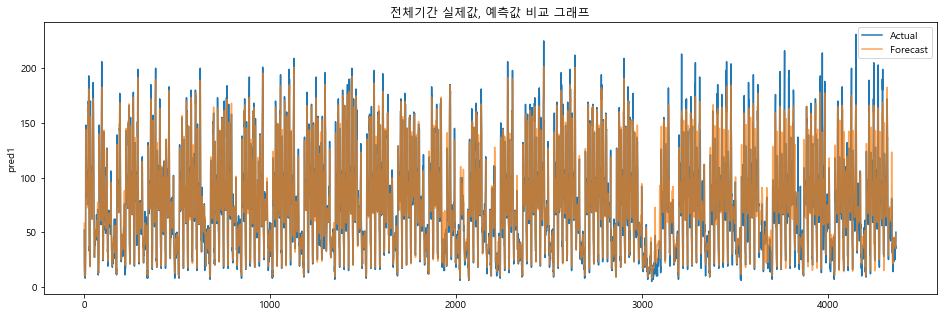

In [502]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi_add_pop.index,y='count',data=taxi_add_pop)
sns.lineplot(x=taxi_add_pop.index,y='pred1',data=taxi_add_pop,alpha=0.7)
plt.legend(['Actual','Forecast'])
plt.show()

#### 한달

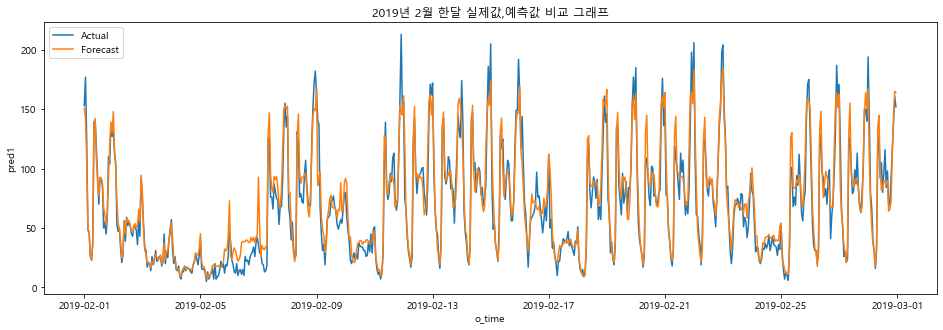

In [506]:
plt.figure(figsize=(16,5))
plt.title('2019년 2월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=taxi_add_pop['2019-02'].index,y='count',data=taxi_add_pop['2019-02'])
sns.lineplot(x=taxi_add_pop['2019-02'].index,y='pred1',data=taxi_add_pop['2019-02'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 일주일

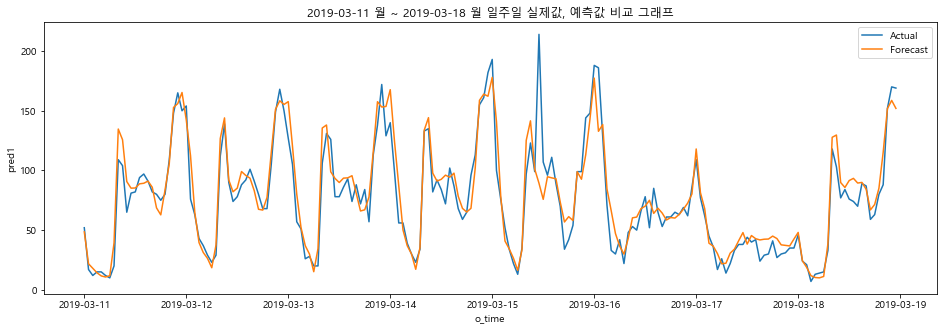

In [507]:
plt.figure(figsize=(16,5))
plt.title('2019-03-11 월 ~ 2019-03-18 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi_add_pop['2019-03-11':'2019-03-18'].index,y='count',data=taxi_add_pop['2019-03-11':'2019-03-18'])
sns.lineplot(x=taxi_add_pop['2019-03-11':'2019-03-18'].index,y='pred1',data=taxi_add_pop['2019-03-11':'2019-03-18'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 한글날 ytt 업데이트 x

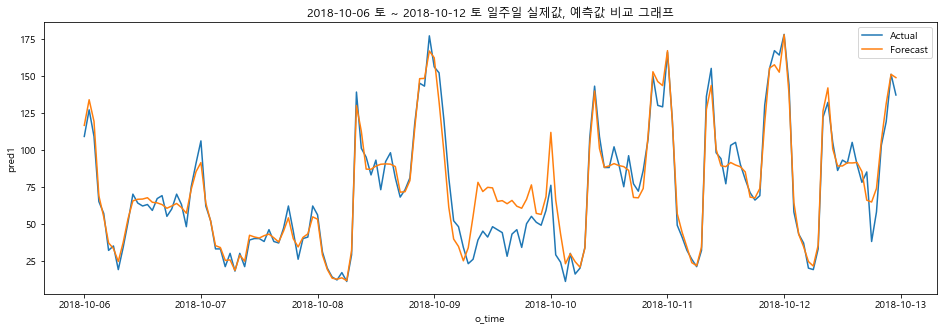

In [508]:
plt.figure(figsize=(16,5))
plt.title('2018-10-06 토 ~ 2018-10-12 토 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='count',data=taxi['2018-10-06':'2018-10-12'])
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='pred1',data=taxi['2018-10-06':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

### 한글날 ytt 업데이트

In [509]:
taxi_add_pop['ytt'] = taxi_add_pop['ytt'].astype('str')
taxi_add_pop['2018-10-08'].ytt = '101'
taxi_add_pop['2018-10-09'].ytt = '010'
taxi_add_pop['2018-10-10'].ytt = '100'
taxi_add_pop['ytt'] = taxi_add_pop['ytt'].astype('category')
taxi_add_pop['2018-10-08':'2018-10-10']

,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,pop,count,pred1
o_time,,,,,,,,,,,,,
2018-10-08 00:00:00,0,101,12.3,0.8,44,0.0,0.0,0.0,2000,1.0,328.36,56,56.21
2018-10-08 01:00:00,1,101,11.7,1.1,52,1.0,0.0,0.0,2000,1.0,244.22,31,29.50
2018-10-08 02:00:00,2,101,11.1,1.4,56,3.0,0.0,0.0,2000,1.0,170.25,20,18.61
2018-10-08 03:00:00,3,101,10.8,0.5,59,1.0,0.0,0.0,2000,1.0,161.00,14,14.57
2018-10-08 04:00:00,4,101,10.4,0.6,61,1.0,0.0,0.0,2000,1.0,242.38,12,12.69
2018-10-08 05:00:00,5,101,9.8,0.5,63,1.0,0.0,0.0,2000,1.0,1474.69,17,14.66
2018-10-08 06:00:00,6,101,9.5,0.9,68,1.0,0.0,0.0,2000,1.0,4028.41,11,11.62
2018-10-08 07:00:00,7,101,9.2,1.0,72,3.0,0.0,0.0,2000,1.0,12059.28,29,31.12
2018-10-08 08:00:00,8,101,9.9,1.2,66,7.0,0.0,0.0,2000,1.0,13639.86,139,130.46


In [510]:
ytt_update = taxi_add_pop.reset_index(inplace=False)
ytt_update = ytt_update.drop(['o_time','count','pred1'],axis=1)
ytt_update.head()

,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,pop
0,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,299.31
1,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,196.59
2,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,173.37
3,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,131.52
4,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,254.17


In [511]:
a = final_rf_model2.predict(ytt_update)
taxi_add_pop['pred2'] = a

In [512]:
evaluate_regr(taxi_add_pop['count'],a)

MAE : 6.150, MSE : 97.305, RMSE : 9.864, RMSLE : 0.153


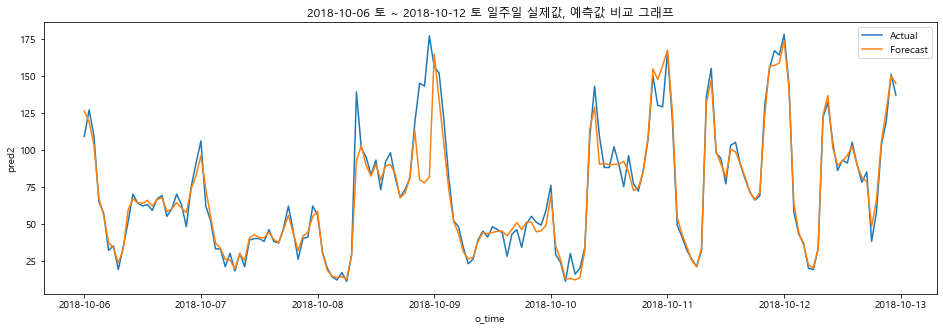

In [513]:
plt.figure(figsize=(16,5))
plt.title('2018-10-06 토 ~ 2018-10-12 토 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi_add_pop['2018-10-06':'2018-10-12'].index,y='count',data=taxi_add_pop['2018-10-06':'2018-10-12'])
sns.lineplot(x=taxi_add_pop['2018-10-06':'2018-10-12'].index,y='pred2',data=taxi_add_pop['2018-10-06':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

## 시계열 교차검증 (유동인구 컬럼 X 데이터)

### 파라미터 리스트작성 및 GridSearchCV 사용 튜닝

In [610]:
params = {"n_estimators": [50,100,500],
          "max_depth":[10,12,50],}
          #'min_samples_leaf': [1, 2, 4],
          #'min_samples_split': [2, 5, 10]
          #}
""",
          {}"bootstrap": [True, False],
          "max_features": ["auto", "log2", "sqrt"]}
"""
rf_rg = RandomForestRegressor(min_samples_split=12)

tscv = TimeSeriesSplit(n_splits=6)
gscv = GridSearchCV(rf_rg, params, cv=tscv, scoring='neg_mean_squared_error')
gscv.fit(X_train1,y_train1)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=6),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=12,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 500], 'max_depth': [10, 12, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

### 최적의 파라미터, 해당 파라미터 모델의 MSE

In [611]:
print('final params : ', gscv.best_params_)
print('best RMSE : ', np.sqrt(np.abs(gscv.best_score_)))

final params :  {'max_depth': 12, 'n_estimators': 500}
best RMSE :  17.864500185071865


### 튜닝한 최적의 파라미터로 모델 생성 및 평가

In [667]:
final_rf_model3 = gscv.best_estimator_

final_rf_model3.fit(X_train1,y_train1)
pred = final_rf_model3.predict(X_test1)

evaluate_regr(y_test1,pred)

MAE : 11.115, MSE : 240.587, RMSE : 15.511, RMSLE : 0.252


In [695]:
final_rf_model3

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=12,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [662]:
final_rf_model3

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=12,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### feature 중요도 시각화

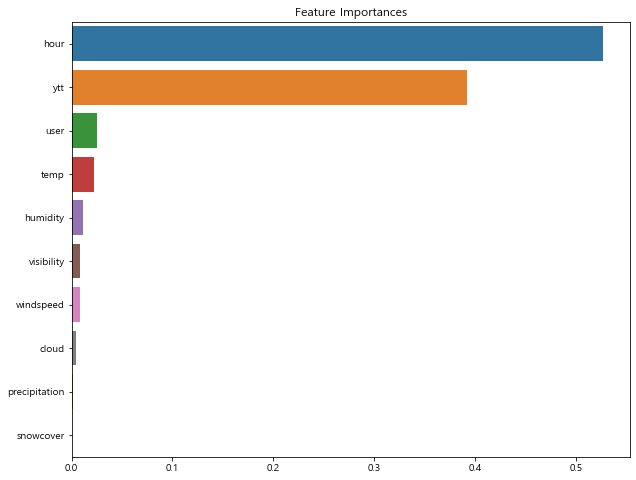

In [614]:
ftr_importances_values = final_rf_model3.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train1.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

### 튜닝한 파라미터 모델로 전체데이터 예측

In [588]:
total_data3 = data1.drop('count',axis=1,inplace=False)
total_data3.head()

,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user
0,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0
1,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0
2,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0
3,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0
4,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0


In [696]:
c = final_rf_model3.predict(total_data3)
taxi['pred3'] = c

#taxi.set_index('o_time',inplace=True)

In [697]:
evaluate_regr(taxi['count'],c)

MAE : 8.691, MSE : 151.279, RMSE : 12.300, RMSLE : 0.195


#### 전체기간

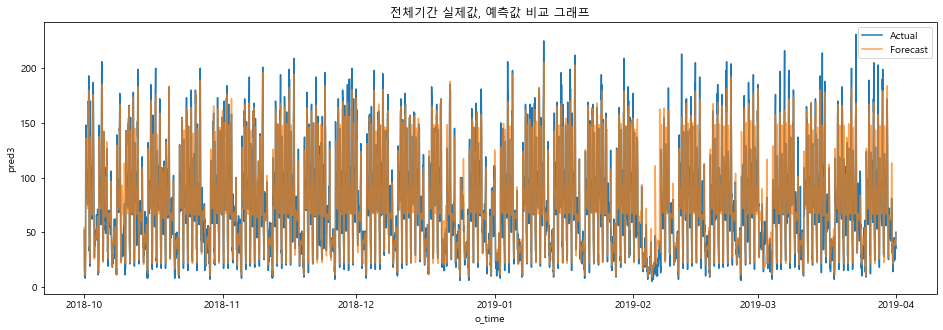

In [591]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi.index,y='count',data=taxi)
sns.lineplot(x=taxi.index,y='pred3',data=taxi,alpha=0.7)
plt.legend(['Actual','Forecast'])
plt.show()

#### 한달

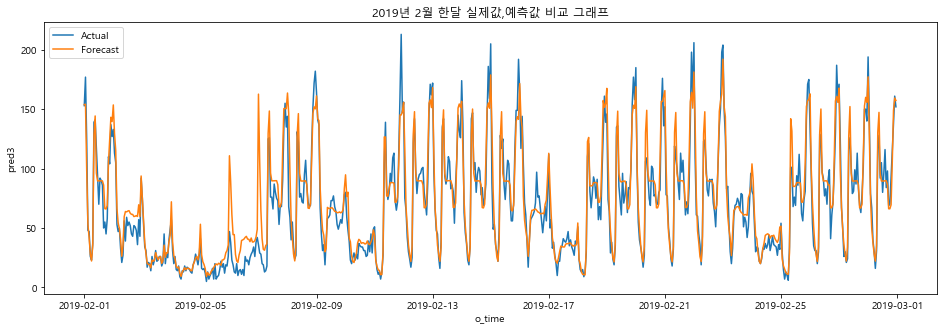

In [592]:
plt.figure(figsize=(16,5))
plt.title('2019년 2월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=taxi['2019-02'].index,y='count',data=taxi['2019-02'])
sns.lineplot(x=taxi['2019-02'].index,y='pred3',data=taxi['2019-02'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 일주일

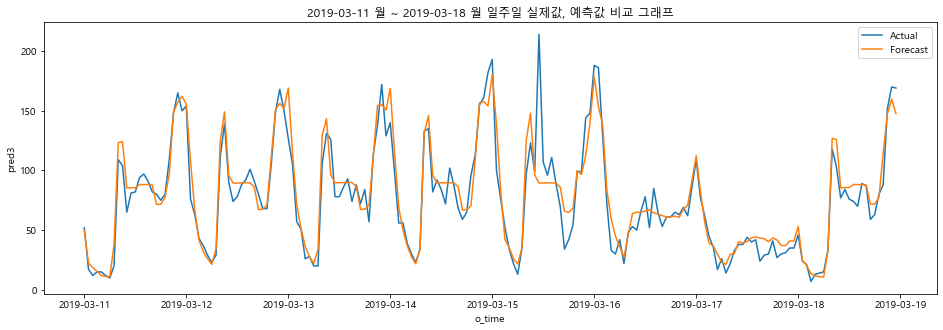

In [593]:
plt.figure(figsize=(16,5))
plt.title('2019-03-11 월 ~ 2019-03-18 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2019-03-11':'2019-03-18'].index,y='count',data=taxi['2019-03-11':'2019-03-18'])
sns.lineplot(x=taxi['2019-03-11':'2019-03-18'].index,y='pred3',data=taxi['2019-03-11':'2019-03-18'])
plt.legend(['Actual','Forecast'])
plt.show()

## 시계열 교차검증 (유동인구 컬럼 O 데이터)

### 파라미터 리스트작성 및 GridSearchCV 사용 튜닝

In [635]:
params = {"n_estimators": [100,500],
          "max_depth":[10,12,50],}
          #'min_samples_leaf': [1, 2, 4],
          #'min_samples_split': [2, 5, 10]
          #}
""",
          {}"bootstrap": [True, False],
          "max_features": ["auto", "log2", "sqrt"]}
"""
rf_rg = RandomForestRegressor()

tscv = TimeSeriesSplit(n_splits=4)
gscv = GridSearchCV(rf_rg, params, cv=tscv, scoring='neg_mean_squared_error')
gscv.fit(X_train2,y_train2)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 500], 'max_depth': [10, 12, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

### 최적의 파라미터, 해당 파라미터 모델의 MSE

In [636]:
print('final params : ', gscv.best_params_)
print('best RMSE : ', np.sqrt(np.abs(gscv.best_score_)))

final params :  {'max_depth': 50, 'n_estimators': 500}
best RMSE :  18.972088055524605


### 튜닝한 최적의 파라미터로 모델 생성 및 평가

In [637]:
final_rf_model4 = gscv.best_estimator_

final_rf_model4.fit(X_train2,y_train2)
pred = final_rf_model4.predict(X_test2)

evaluate_regr(y_test2,pred)

MAE : 11.117, MSE : 233.283, RMSE : 15.274, RMSLE : 0.241


In [661]:
final_rf_model4

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### 튜닝한 파라미터 모델로 전체데이터 예측

In [629]:
total_data4 = data2.drop('count',axis=1,inplace=False)
total_data4.head()

,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,pop
0,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,299.31
1,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,196.59
2,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,173.37
3,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,131.52
4,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,254.17


In [638]:
d = final_rf_model4.predict(total_data4)
taxi_add_pop['pred3'] = d

#taxi.set_index('o_time',inplace=True)

In [639]:
evaluate_regr(taxi_add_pop['count'],d)

MAE : 6.012, MSE : 90.844, RMSE : 9.531, RMSLE : 0.150


#### 전체기간

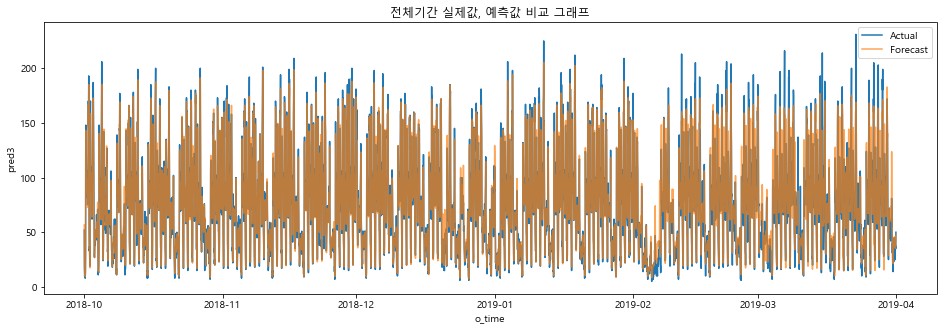

In [644]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi_add_pop.index,y='count',data=taxi_add_pop)
sns.lineplot(x=taxi_add_pop.index,y='pred3',data=taxi_add_pop,alpha=0.7)
plt.legend(['Actual','Forecast'])
plt.show()

#### 한달

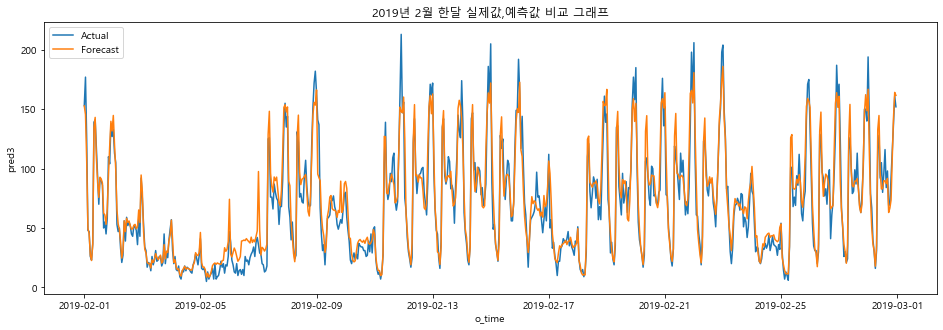

In [645]:
plt.figure(figsize=(16,5))
plt.title('2019년 2월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=taxi_add_pop['2019-02'].index,y='count',data=taxi_add_pop['2019-02'])
sns.lineplot(x=taxi_add_pop['2019-02'].index,y='pred3',data=taxi_add_pop['2019-02'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 일주일

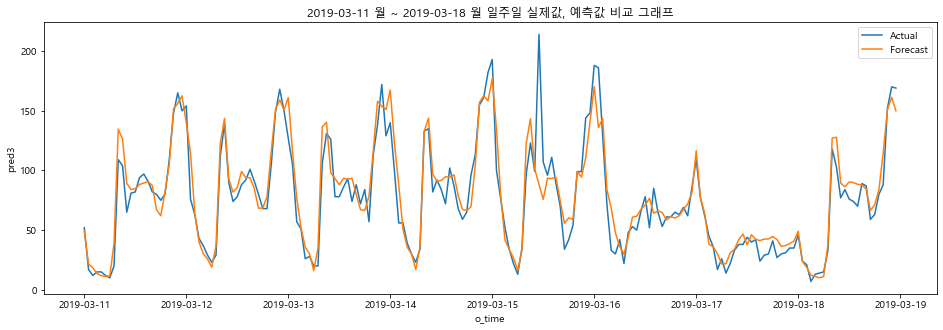

In [646]:
plt.figure(figsize=(16,5))
plt.title('2019-03-11 월 ~ 2019-03-18 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi_add_pop['2019-03-11':'2019-03-18'].index,y='count',data=taxi_add_pop['2019-03-11':'2019-03-18'])
sns.lineplot(x=taxi_add_pop['2019-03-11':'2019-03-18'].index,y='pred3',data=taxi_add_pop['2019-03-11':'2019-03-18'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 한글날 ytt 업데이트 

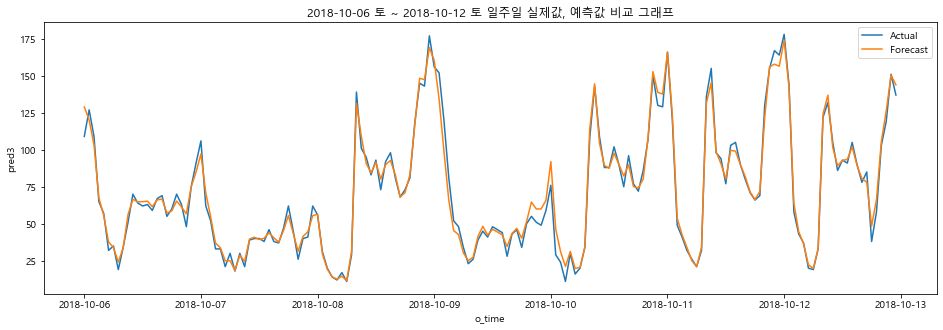

In [656]:
plt.figure(figsize=(16,5))
plt.title('2018-10-06 토 ~ 2018-10-12 토 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi_add_pop['2018-10-06':'2018-10-12'].index,y='count',data=taxi_add_pop['2018-10-06':'2018-10-12'])
sns.lineplot(x=taxi_add_pop['2018-10-06':'2018-10-12'].index,y='pred3',data=taxi_add_pop['2018-10-06':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()